In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

tf.random.set_seed(0)
np.random.seed(0)

#after much training, i made the omega trainable so as to find the perfect omega along with the weights and appoximation
omega = tf.Variable(2.5, dtype=tf.float32, trainable=True)

alpha = 0.1

In [2]:
t = np.linspace(0, 10, 800).reshape(-1, 1)
x_true = np.exp(-alpha * omega * t) * np.sin(omega * t)

t_tf = tf.convert_to_tensor(t, dtype=tf.float32)

# few points for data loss
points = [0, 40, 80, 120, 160]
t_data = tf.convert_to_tensor(t[points], dtype=tf.float32)
x_data = tf.convert_to_tensor(x_true[points], dtype=tf.float32)

#normalizing time (important for PINNs)
t_mean = tf.reduce_mean(t_tf)
t_std = tf.math.reduce_std(t_tf)

t_norm = (t_tf - t_mean) / t_std
t_data_norm = (t_data - t_mean) / t_std


In [3]:
def create_model(activation):
    model = {
        "dense1": tf.keras.layers.Dense(100, activation=activation),
        "dense2": tf.keras.layers.Dense(100, activation=activation),
        "dense3": tf.keras.layers.Dense(100, activation=activation),
        "output": tf.keras.layers.Dense(1)
    }
    return model


In [4]:
def call_model(model, x):
    x = model['dense1'](x)
    x = model['dense2'](x)
    x = model['dense3'](x)
    x = model['output'](x)
    return x

In [5]:
def pde_residual(model, t):
    with tf.GradientTape(persistent=True) as tape2:
        tape2.watch(t)
        with tf.GradientTape() as tape1:
            tape1.watch(t)
            x = call_model(model, t)
        dx_dt = tape1.gradient(x, t)
    d2x_dt2 = tape2.gradient(dx_dt, t)
    del tape2
    return d2x_dt2 + 2*alpha*omega*dx_dt + omega**2 * x


In [6]:
activation = "tanh"
epochs = 5001

pinn = create_model(activation)
optimizer_pinn = tf.keras.optimizers.Adam(1e-3)

# Build model before as there are no inputs and it was giving 'Dense' error
_ = call_model(pinn, tf.zeros((1, 1)))

# Collect trainable variables
trainable_vars_pinn = []
trainable_vars_pinn.append(omega)
for layer in pinn.values():
    trainable_vars_pinn.extend(layer.trainable_variables)


In [7]:
for epoch in range(epochs):
    lambda_phys = min(1.0, epoch / 2000)
    lambda_data = 50.0
    lambda_ic   = 100.0

    with tf.GradientTape() as tape:
        # Physics loss
        res = pde_residual(pinn, t_norm)
        loss_phys = tf.reduce_mean(tf.square(res))

        # Data loss
        x_pred_data = call_model(pinn, t_data_norm)
        loss_data = tf.reduce_mean(tf.square(x_data - x_pred_data))

        # Initial condition loss
        t0 = tf.zeros((1,1), dtype=tf.float32)
        with tf.GradientTape() as tape_ic:
            tape_ic.watch(t0)
            x0 = call_model(pinn, t0)
        dx0_dt = tape_ic.gradient(x0, t0)

        loss_ic = tf.square(x0) + tf.square(dx0_dt - omega)

        # Total loss (weighted)
        loss = (
        lambda_phys * loss_phys +
        lambda_data * loss_data +
        lambda_ic   * loss_ic)


    grads = tape.gradient(loss, trainable_vars_pinn)
    optimizer_pinn.apply_gradients(zip(grads, trainable_vars_pinn))

    if epoch % 1000 == 0:
       print(f"PINN Epoch {epoch}, Loss = {float(loss):.3e}")


PINN Epoch 0, Loss = 5.957e+02
PINN Epoch 1000, Loss = 8.673e+00
PINN Epoch 2000, Loss = 7.641e+00
PINN Epoch 3000, Loss = 7.457e+00
PINN Epoch 4000, Loss = 7.440e+00
PINN Epoch 5000, Loss = 7.437e+00


In [8]:
nn = create_model(activation)
optimizer_nn = tf.keras.optimizers.Adam(1e-3)

_ = call_model(nn, tf.zeros((1,1)))

trainable_vars_nn = []
for layer in nn.values():
    trainable_vars_nn.extend(layer.trainable_variables)

In [9]:
for epoch in range(epochs):
    with tf.GradientTape() as tape:
        x_pred = call_model(nn, t_data_norm)
        loss = tf.reduce_mean(tf.square(x_data - x_pred))

    grads = tape.gradient(loss, trainable_vars_nn)
    optimizer_nn.apply_gradients(zip(grads, trainable_vars_nn))

    if epoch % 1000 == 0:
        print(f"NN Epoch {epoch}, Loss = {float(loss):.3e}")


NN Epoch 0, Loss = 3.562e-01
NN Epoch 1000, Loss = 3.216e-06
NN Epoch 2000, Loss = 1.623e-08
NN Epoch 3000, Loss = 2.720e-08
NN Epoch 4000, Loss = 1.620e-11
NN Epoch 5000, Loss = 1.628e-09


In [10]:
x_pinn = call_model(pinn, t_tf).numpy()
x_nn = call_model(nn, t_tf).numpy()


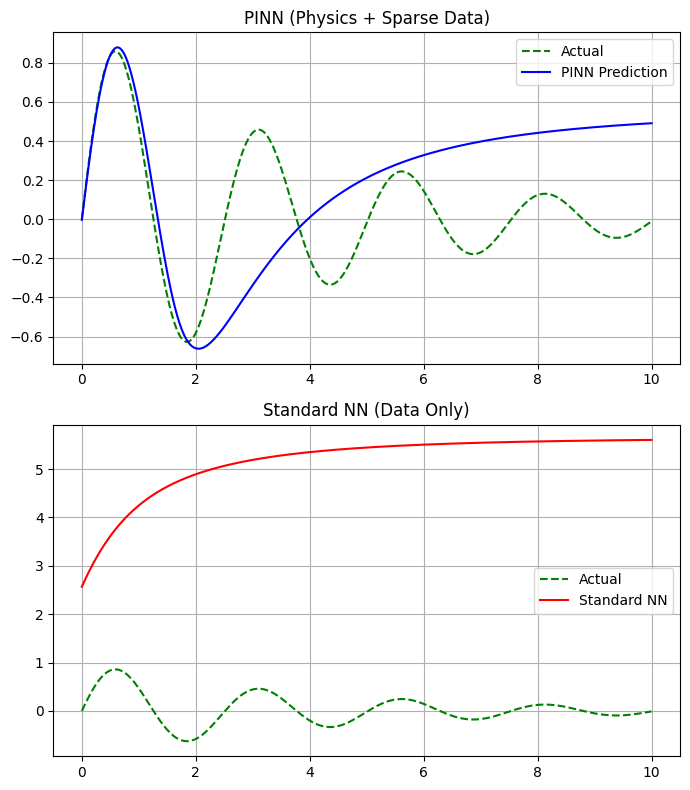

In [12]:
plt.figure(figsize=(7, 8))

plt.subplot(2, 1, 1)
plt.plot(t, x_true, "g--", label="Actual")
plt.plot(t, x_pinn, "b", label="PINN Prediction")
plt.title("PINN (Physics + Sparse Data)")
plt.legend()
plt.grid()

plt.subplot(2, 1, 2)
plt.plot(t, x_true, "g--", label="Actual")
plt.plot(t, x_nn, "r", label="Standard NN")
plt.title("Standard NN (Data Only)")
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

In [ ]:
# The PINNs are not accurately able to capture the high frequency oscillations because of the small omega value learned.
# Tried increasing the number of layers and neurons but it did not help much.
# So I have asked the mentor about this issue.